In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('Combined Data.csv', index_col=0)


In [4]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
df.shape


(53043, 2)

In [6]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [8]:
df.isna().sum()

,0
statement,362
status,0


In [9]:
df.dropna(inplace = True)
df.isna().sum()

,0
statement,0
status,0


In [10]:
df.status.value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


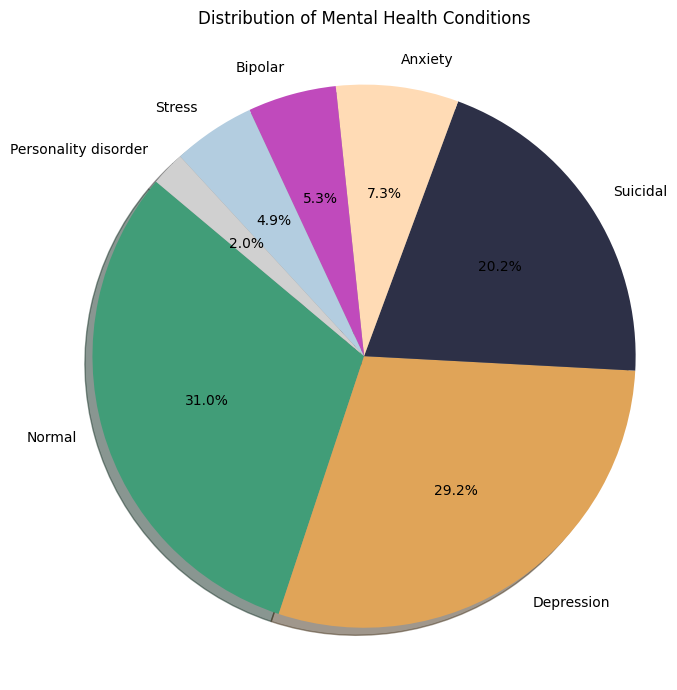

In [11]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

In [12]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Don't worry, karma is there, hauuuhzzzz

Status: Bipolar
Statement: Brother committed, diagnosed, home. Still manic? My brother 26 was committed for a manic episode, diagnosed bipolar and was released today. Immedietly drank with his buddies, took the brand new truck he bought during this manic episode and blew up at my dad for making payments on his over drawn accounts. He was committed for 20 days, but just started the bipolar medication about 10 days ago. He looks and sounds so much better, but he's still talking about how intelligent he is and that he has all of his finances in order and knows what he's doing. I'm afraid he hasn't actually accepted the diagnosis or realised just how much of a mess there is to clean up. He started his own company this year, and I'm scared to death all of his financial issues will get so much worse. He doesn't seem to care, says he feels amazing and is planning on furthering his business. I guess my question is how do I app

In [13]:
import nltk
nltk.download('punkt_tab')

# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


In [14]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


In [15]:
# Mengubah teks dalam kolom 'statement' menjadi lowercase
df['statement'] = df['statement'].astype(str).str.lower()

# Menampilkan 5 data pertama untuk memastikan perubahan berhasil
print(df.head())


                                           statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  all wrong, back off dear, forward doubt. stay ...  Anxiety   
3  i've shifted my focus to something else but i'...  Anxiety   
4  i'm restless and restless, it's been a month n...  Anxiety   

   num_of_characters  num_of_sentences  
0                 10                 1  
1                 64                 2  
2                 78                 2  
3                 61                 1  
4                 72                 2  


In [16]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,statement,status,num_of_characters,num_of_sentences
0,oh my gosh,Anxiety,10,1
1,trouble sleeping confused mind restless heart ...,Anxiety,64,2
2,all wrong back off dear forward doubt stay in ...,Anxiety,78,2
3,ive shifted my focus to something else but im ...,Anxiety,61,1
4,im restless and restless its been a month now ...,Anxiety,72,2


**Tokenisasi**

In [17]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,statement,status,num_of_characters,num_of_sentences,tokens
0,oh my gosh,Anxiety,10,1,"[oh, my, gosh]"
1,trouble sleeping confused mind restless heart ...,Anxiety,64,2,"[trouble, sleeping, confused, mind, restless, ..."
2,all wrong back off dear forward doubt stay in ...,Anxiety,78,2,"[all, wrong, back, off, dear, forward, doubt, ..."
3,ive shifted my focus to something else but im ...,Anxiety,61,1,"[ive, shifted, my, focus, to, something, else,..."
4,im restless and restless its been a month now ...,Anxiety,72,2,"[im, restless, and, restless, its, been, a, mo..."


In [18]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,statement,status,num_of_characters,num_of_sentences,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,"[oh, my, gosh]",oh my gosh
1,trouble sleeping confused mind restless heart ...,Anxiety,64,2,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,all wrong back off dear forward doubt stay in ...,Anxiety,78,2,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,ive shifted my focus to something else but im ...,Anxiety,61,1,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,im restless and restless its been a month now ...,Anxiety,72,2,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


In [19]:
from nltk.stem import WordNetLemmatizer

# Pastikan WordNet sudah diunduh
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()

# Fungsi untuk lemmatization
def lemmatize_tokens(tokens):
    return ' '.join(lemmatizer.lemmatize(str(token)) for token in tokens)

# Terapkan lemmatization ke kolom 'tokens'
df['tokens_lemmatized'] = df['tokens_stemmed'].apply(lemmatize_tokens)

df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,statement,status,num_of_characters,num_of_sentences,tokens,tokens_stemmed,tokens_lemmatized
0,oh my gosh,Anxiety,10,1,"[oh, my, gosh]",oh my gosh,o h m y g o s h
1,trouble sleeping confused mind restless heart ...,Anxiety,64,2,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...,t r o u b l s l e e p c o n f u s m i n ...
2,all wrong back off dear forward doubt stay in ...,Anxiety,78,2,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...,a l l w r o n g b a c k o f f d e a r ...
3,ive shifted my focus to something else but im ...,Anxiety,61,1,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...,i v e s h i f t m y f o c u t o s o ...
4,im restless and restless its been a month now ...,Anxiety,72,2,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...,i m r e s t l e s s a n d r e s t l e s ...


In [20]:
from nltk.corpus import stopwords

# Pastikan stopwords sudah diunduh
nltk.download('stopwords')

# Ambil daftar stopwords bahasa Inggris
stop_words = set(stopwords.words('english'))

# Fungsi untuk menghapus stopwords dari token
def remove_stopwords(tokens):
    return ' '.join(word for word in tokens if word.lower() not in stop_words)

# Terapkan fungsi ke kolom 'tokens'
df['tokens_no_stopwords'] = df['tokens_lemmatized'].apply(remove_stopwords)

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,statement,status,num_of_characters,num_of_sentences,tokens,tokens_stemmed,tokens_lemmatized,tokens_no_stopwords
0,oh my gosh,Anxiety,10,1,"[oh, my, gosh]",oh my gosh,o h m y g o s h,h g h
1,trouble sleeping confused mind restless heart ...,Anxiety,64,2,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...,t r o u b l s l e e p c o n f u s m i n ...,r u b l l e e p ...
2,all wrong back off dear forward doubt stay in ...,Anxiety,78,2,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...,a l l w r o n g b a c k o f f d e a r ...,l l w r n g b c ...
3,ive shifted my focus to something else but im ...,Anxiety,61,1,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...,i v e s h i f t m y f o c u t o s o ...,v e h f f ...
4,im restless and restless its been a month now ...,Anxiety,72,2,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...,i m r e s t l e s s a n d r e s t l e s ...,r e l e n ...


In [21]:
 # Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **Teknik Ekstraksi Fitur (Tahap 2)**

**Bag-of-Words (BoW)**

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan tidak ada data kosong pada kolom 'tokens_lemmatized'
df = df.dropna(subset=['tokens'])

# Gabungkan token lemmatized menjadi string (karena isinya list)
df['lemmatized_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# Buat BoW setelah lemmatization
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(df['lemmatized_text'])

# Konversi hasil BoW menjadi DataFrame
df_bow = pd.DataFrame(X_bow.toarray(), columns=vectorizer_bow.get_feature_names_out())

# # Hitung total kemunculan tiap kata
# word_freq = np.asarray(X_bow.sum(axis=0)).flatten()
# word_freq_sorted_idx = np.argsort(word_freq)[::-1]  # Urutkan dari besar ke kecil

# # Ambil 10 kata dengan frekuensi tertinggi
# top_n = 10
# top_words = np.array(vectorizer_bow.get_feature_names_out())[word_freq_sorted_idx[:top_n]]
# top_frequencies = word_freq[word_freq_sorted_idx[:top_n]]

# # Tampilkan 10 kata paling sering
# print(pd.DataFrame({'Kata': top_words, 'Frekuensi': top_frequencies}))

# # Visualisasi Bar Chart
# plt.figure(figsize=(10, 5))
# sns.barplot(x=top_frequencies, y=top_words, palette="Blues_r")
# plt.xlabel("Frekuensi")
# plt.ylabel("Kata")
# plt.title("10 Kata Paling Sering Muncul dalam BoW (Setelah Lemmatization)")
# plt.show()


# **KLASIFIKASI NAIVE BAYES**

In [23]:
print(df.columns)


Index(['statement', 'status', 'num_of_characters', 'num_of_sentences',
       'tokens', 'tokens_stemmed', 'tokens_lemmatized', 'tokens_no_stopwords',
       'lemmatized_text'],
      dtype='object')


In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

# Pastikan data sudah bersih
df = df.dropna(subset=['tokens_lemmatized'])

# Gabungkan token menjadi kalimat string untuk BoW
df['lemmatized_text'] = df['tokens_lemmatized'].apply(lambda x: ' '.join(x))

# Siapkan data dan label
X_text = df['statement']
y = df['status']  # Ganti sesuai nama kolom label pada datasetmu

# Buat BoW vectorizer
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(X_text)

# Split data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

# Training model Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Prediksi
y_pred = nb_model.predict(X_test)

# Evaluasi
print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Akurasi: 0.6509442915440827

Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.70      0.77      0.73       755
             Bipolar       0.66      0.68      0.67       527
          Depression       0.50      0.71      0.59      3016
              Normal       0.93      0.64      0.76      3308
Personality disorder       0.66      0.11      0.19       237
              Stress       0.65      0.18      0.28       536
            Suicidal       0.65      0.72      0.68      2158

            accuracy                           0.65     10537
           macro avg       0.68      0.54      0.56     10537
        weighted avg       0.70      0.65      0.65     10537


Confusion Matrix:
 [[ 579   23  119   22    1    6    5]
 [  15  357  147    6    0    1    1]
 [  43   54 2149   84    7    7  672]
 [  93   50  856 2105    6   36  162]
 [   6   11  188    4   27    0    1]
 [  88   32  307    8    0   96    5]
 [   9   12  5

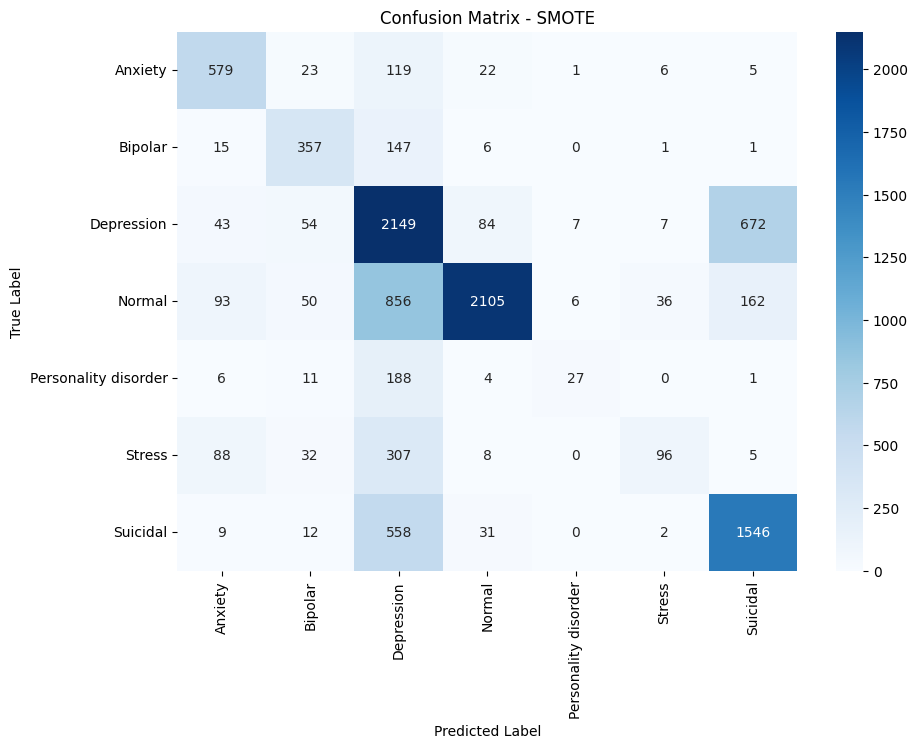

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)
labels = nb_model.classes_

# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **LogisticRegression SMOTE**


In [26]:
pip install imbalanced-learn


Percobaan 2

Akurasi: 0.7838094334250736

Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.79      0.85      0.82       755
             Bipolar       0.79      0.81      0.80       527
          Depression       0.77      0.67      0.72      3016
              Normal       0.89      0.94      0.91      3308
Personality disorder       0.74      0.76      0.75       237
              Stress       0.62      0.65      0.63       536
            Suicidal       0.68      0.71      0.69      2158

            accuracy                           0.78     10537
           macro avg       0.75      0.77      0.76     10537
        weighted avg       0.78      0.78      0.78     10537


Confusion Matrix:
 [[ 639   18   25   34    8   27    4]
 [  14  428   35   17    7   18    8]
 [  61   46 2029  135   22   65  658]
 [  28   10   41 3108    9   71   41]
 [   8    9   13    9  179   16    3]
 [  46   21   37   52   14  350   16]
 [  11    9  4

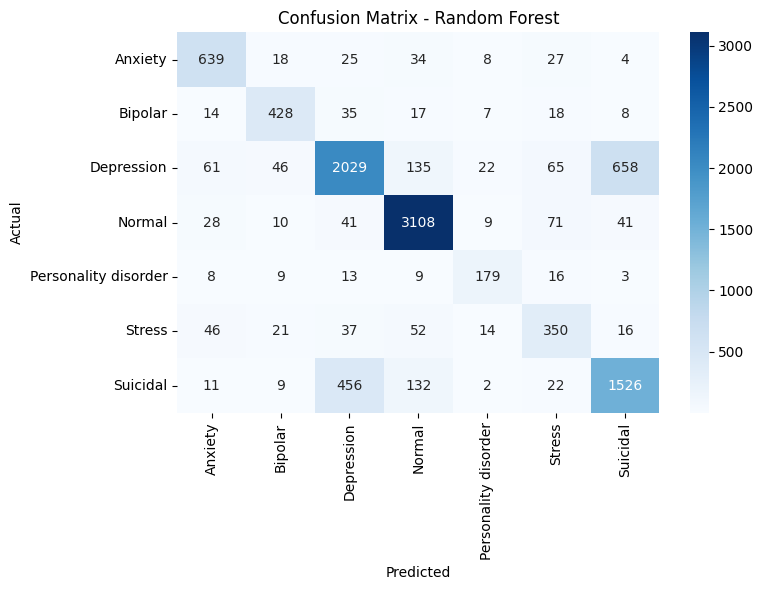

In [27]:
# Import Library
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Preparation ---
# Pastikan kolom tokens_lemmatized tidak kosong
df = df.dropna(subset=['tokens_lemmatized'])

# Gabungkan token menjadi kalimat string
df['lemmatized_text'] = df['tokens_lemmatized'].apply(lambda x: ' '.join(x))

# # (Optional) Gabungkan label menjadi kategori besar agar lebih seimbang
# def map_labels(label):
#     if label in ['Depression', 'Suicidal']:
#         return 'Depressive'
#     elif label in ['Stress', 'Anxiety']:
#         return 'Anxious'
#     elif label in ['Bipolar', 'Personality disorder']:
#         return 'Mood'
#     else:
#         return 'Normal'

df['label_grouped'] = df['status']

# --- Vectorization ---
X_text = df['statement']
y = df['label_grouped']

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)

# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# --- Model: Random Forest with Balanced Class Weight ---

model = LinearSVC(class_weight='balanced')

model.fit(X_train, y_train)

# --- Evaluation ---
y_pred = model.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- Visualisasi Confusion Matrix ---
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()


Percobaan 4 smv td idf

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer # Ganti import
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# ... (kode persiapan df tetap sama) ...
X_text = df['statement']
y = df['status']

# Ganti CountVectorizer dengan TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

# Split data TF-IDF
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Training model SVM dengan data TF-IDF
# Cukup tambahkan class_weight='balanced'
svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

# Prediksi
y_pred = svm_model.predict(X_test)

# Evaluasi
print("Akurasi (SVM dengan TF-IDF):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Akurasi (SVM dengan TF-IDF): 0.7833349150612129

Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.79      0.85      0.82       755
             Bipolar       0.76      0.83      0.79       527
          Depression       0.80      0.64      0.71      3016
              Normal       0.90      0.92      0.91      3308
Personality disorder       0.73      0.72      0.73       237
              Stress       0.58      0.72      0.64       536
            Suicidal       0.67      0.76      0.71      2158

            accuracy                           0.78     10537
           macro avg       0.75      0.78      0.76     10537
        weighted avg       0.79      0.78      0.78     10537



Percobaan SMOTE data

In [ ]:
# Anda perlu install library imbalanced-learn terlebih dahulu
# pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from collections import Counter

# Terapkan SMOTE HANYA pada data training
smote = SMOTE(random_state=42)
print(f"Distribusi kelas sebelum SMOTE: {Counter(y_train)}")

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Distribusi kelas setelah SMOTE: {Counter(y_train_resampled)}")

# Sekarang, latih model dengan data yang sudah di-resampling
svm_model = SVC(kernel='linear', random_state=42) # class_weight tidak perlu lagi jika sudah pakai SMOTE
svm_model.fit(X_train_resampled, y_train_resampled)

# Prediksi dan evaluasi tetap menggunakan X_test dan y_test yang asli
y_pred = svm_model.predict(X_test)
print("Akurasi (setelah SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)
labels = svm_model.classes_

# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)
labels = nb_model.classes_

# Visualisasi confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load the dataframe (ensure 'Combined Data.csv' is in the correct path)
df = pd.read_csv('Combined Data.csv', index_col=0)

# Pastikan kolom 'statement' tidak kosong
df = df.dropna(subset=['statement'])

vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(df['statement'])
print("BoW Feature Shape:", X_bow.shape)

In [ ]:
import pandas as pd

# Konversi hasil BoW menjadi DataFrame
df_bow = pd.DataFrame(X_bow.toarray(), columns=vectorizer_bow.get_feature_names_out())

# Tampilkan beberapa baris pertama
df_bow.head()

**TF-IDF (Term Frequency - Inverse Document Frequency)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Pastikan tidak ada nilai kosong pada kolom 'statement'
df = df.dropna(subset=['statement'])

vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(df['statement'])
print("TF-IDF Feature Shape:", X_tfidf.shape)


Word Embeddings (Word2Vec, GloVe, FastText)

In [ ]:
!pip install gensim

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors

nltk.download('punkt')


In [ ]:
# Melatih model Word2Vec
# Tokenize the 'statement' column first
tokenized_text = df['statement'].apply(word_tokenize).tolist()

# Then, train the Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
word_vectors_w2v = word2vec_model.wv

# Fungsi untuk mendapatkan vektor rata-rata dari kalimat
def get_sentence_vector_w2v(sentence):
    words = word_tokenize(sentence.lower())
    vectors = [word_vectors_w2v[word] for word in words if word in word_vectors_w2v]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

# Ensure you are using the correct column name ('statement' or 'text')
X_word2vec = np.array([get_sentence_vector_w2v(sentence) for sentence in df['statement']])
print("Word2Vec Feature Shape:", X_word2vec.shape)

In [ ]:
# Melatih model FastText
fasttext_model = FastText(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

# Fungsi untuk mendapatkan vektor rata-rata dari kalimat
def get_sentence_vector_fasttext(sentence):
    words = word_tokenize(sentence.lower())
    vectors = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_fasttext = np.array([get_sentence_vector_fasttext(sentence) for sentence in df['statement']])
print("FastText Feature Shape:", X_fasttext.shape)
